# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** Jessica Guan (230001096) - PG


**IMPORTANT NOTE**: Please make sure to check the timestamp **before running anything**. Because of how my MaskDetectionVideo works (I had issues with the HTML video player, I am saving the processed video after using Resnet model to predict and display the bounding face detection box and class label to the drive, then displaying the video in Colab with a python video package). Because of this, I had to grant "Editor" permission to the Video folder. This **shouldn't** effect the time stamp of this notebook or any of the code, but I am leaving this note here just in case.

You can also check the "activity" tab for the notebook to see my last changes and that I did not change anything after the deadline, in addition to the (copied and pasted) PDF version of the code is the same. :)



# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['.DS_Store', 'CW_Dataset', 'Models', 'Code', 'Video', 'test_functions.ipynb']


### Load packages

In the next cell you should load all the packages required to test your functions.

In [ ]:
!pip install facenet-pytorch # install if needed, then run cell below to load packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
import os
import random
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
from skimage.transform import resize
import cv2
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from collections import Counter
import joblib
from tensorflow.keras.models import load_model
import tensorflow as tf
import moviepy.editor
from IPython.display import Video, HTML
from moviepy.editor import VideoFileClip
from base64 import b64encode
import torchvision.models as models
import cv2
import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
from facenet_pytorch import MTCNN
from IPython.display import display, HTML
from base64 import b64encode
from torchvision import transforms


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` and `MaskDetectionVideo` to avoid having to reload them each time.

#### Load Resnet50

In [ ]:
# load pretrained resnet-50 model
resnet50 = models.resnet50(weights='IMAGENET1K_V1')

# remove last 2 layers
backbone = nn.Sequential(*list(resnet50.children())[:-2])

# freeze the weights of the backbone layers
for param in backbone.parameters():
    param.requires_grad = False

# number of output features from the backbone
num_ftrs = 2048

# define the classifier
classifier = nn.Sequential(
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(num_ftrs, 300), # linear layer with 300 output features
    nn.ReLU(), # relu activation function
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(300, 3), # linear layer with 3 output features
    nn.Softmax(dim=1) # softmax activation function for multiclass classification
)

# add classifier to backbone
resnet50 = nn.Sequential(
    backbone,
    nn.AdaptiveAvgPool2d((1, 1)), # adaptive average pooling to convert features to 1x1
    nn.Flatten(), # flatten features
    classifier
)

# load the best trained resnet-50 model
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models/resnet50_9.pth')

# move to cpu
resnet50.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

# set to eval mode
resnet50.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

#### Load Mobilenet V2

In [ ]:

# load pretrained mobilenet V2 model
mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')

# freeze weights of the backbone layers
for param in mobilenet.parameters():
    param.requires_grad = False

# number of output features from the backbone
num_ftrs = mobilenet.classifier[-1].in_features

# define new classifier
classifier = nn.Sequential(
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(num_ftrs, 300), # linear layer with 300 output features
    nn.ReLU(), # relu activation function
    nn.Dropout(0.2), # dropout layer with dropout rate 0.2
    nn.Linear(300, 3), # linear layer with 3 output features
    nn.Softmax(dim=1) # softmax activation function for multiclass classification
)

# replace the classifier
mobilenet.classifier = classifier

# load best trained mobilenet model
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Models/mobilenet3.pth')
# move model to cpu
mobilenet.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))

# set to eval mode
mobilenet.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 53.9MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

#### Load custom CNN

In [ ]:
custom_cnn = load_model(os.path.join(GOOGLE_DRIVE_PATH, 'Models/custom_cnn3.keras'))

#### Load HOG + SVM model

In [ ]:
svm_hog = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_hog2.pkl'))

#### Load SIFT + SVM model

In [ ]:
svm_sift = joblib.load(os.path.join(GOOGLE_DRIVE_PATH, 'Models/svm_sift.pkl'))

# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

### Processing functions needed for MaskDetection

In [ ]:
# preprocess function for resnet50 and mobilenet
def preprocess_resnet50_mobilenet(images):
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)), #was 256 # resize to 224
        #transforms.CenterCrop(224),
        transforms.ToTensor(), # convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize with ImageNet stats
    ])
    # apply transforms and add image to processed_images
    processed_images = [data_transforms(image) for image in images]
    return processed_images

# preprocess function for svm_hog
def preprocess_hog(images):
    # list to add processed images to
    processed_images = []
    for img in images:
        # convert to grayscale
        gray_img = rgb2gray(img)
        # resize image to 64x64
        resized_img = resize(gray_img, (64, 64))
        # normalize pixels
        normalized_img = resized_img / 255.0
        processed_images.append(normalized_img)
        # extract HOG features from processed_images
        hog_features = [hog(img, orientations=10, pixels_per_cell=(9, 9), cells_per_block=(3, 3), visualize=False) for img in processed_images]
    return hog_features

# preprocess function for svm_sift
# code reference from lab
def sift_features(images):
    # initialize SIFT detector
    sift = cv2.SIFT_create()

    # empty list for feature descriptors
    des_list = []

    for i in range(len(images)):
        img = img_as_ubyte(color.rgb2gray(images[i])) # convert to grayscale
        kp, des = sift.detectAndCompute(img, None) # identify keypoints and extract descriptors with SIFT

        # add descriptors to list
        if des is not None:
            des_list.append(des)

    # convert to numpy array
    des_array = np.vstack(des_list)

    # set number of codewords/centroids (10*num_classes)
    k = 30

    # set batch size for faster computation and less memory usage
    batch_size = des_array.shape[0] // 4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

    hist_list = []
    idx_list = []

    # convert descriptors into histograms of codewords for each image
    for des in des_list:
        hist = np.zeros(k)
        idx = kmeans.predict(des)
        idx_list.append(idx)
        for j in idx:
            hist[j] = hist[j] + (1 / len(des))
        hist_list.append(hist)

    hist_array = np.vstack(hist_list)

    return des_array

# code reference from lab
def sift_features_test(images, des_array):
    hist_list = []
    sift = cv2.SIFT_create()

    # set number of codewords/centroids (10*num_classes)
    k = 30
    # set batch size for faster computation and less memory usage
    batch_size = des_array.shape[0] // 4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

    for i in range(len(images)):
        img = img_as_ubyte(color.rgb2gray(images[i])) # convert to grayscale
        kp, des = sift.detectAndCompute(img, None) # identify keypoints and extract descriptors with SIFT

        if des is not None:
            hist = np.zeros(kmeans.n_clusters)

            idx = kmeans.predict(des)

            for j in idx:
                hist[j] = hist[j] + (1 / len(des))

            hist_list.append(hist)

        else:
            hist_list.append(None)

    # remove potential cases of images with no descriptors
    idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
    hist_list = [hist_list[i] for i in idx_not_empty]
    hist_array = np.vstack(hist_list)

    return hist_array

# preprocess function for custom_cnn
def preprocess_keras(images):
    # set size to resize images to
    fixed_size = (224, 224)

    #resize images with interpolation
    #reference: https://stackoverflow.com/questions/23853632/which-kind-of-interpolation-best-for-resizing-image
    test_images_resized = [cv2.resize(np.array(image), fixed_size, interpolation=cv2.INTER_LANCZOS4) for image in images]

    # convert resized images to numpy arrays
    test_images_normalized = np.array(test_images_resized)

    # normalize pixels
    test_images_normalized = test_images_normalized.astype('float32') / 255.0
    batch_size = 1

    # create tensorflow dataset
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images_normalized)).batch(batch_size)
    return test_dataset



### Define MaskDetection function

In [ ]:
# path_to_testimages: path to the test images
# path_to_testlabels: path to the test labels
# model: model to test
def MaskDetection(path_to_testimages, path_to_testlabels, model):
    # get list of image files in the test set path
    image_files = os.listdir(path_to_testimages)
    # create list to append the predicted labels
    predicted = []
    # create list to append the random images
    random_images = []
    # randomly select 4 images from the test set
    chosen_image_files = random.sample(image_files, 4)

    # iterate through the image files in chosen_image_files
    for image_file in chosen_image_files:
        image_path = os.path.join(path_to_testimages, image_file) # get the image path to the image file
        image = Image.open(image_path) # open image
        random_images.append(image) # append images to random_image slist

    # create map for the labels
    label_mapping = {}
    # iterate through the image files in chosen_image_files
    for image_file in chosen_image_files:
        label_file = image_file.replace(".jpeg", ".txt")  # create label string with the image file name and .txt
        label_file_path = os.path.join(path_to_testlabels, label_file) # get label file path
        # open the label
        with open(label_file_path, 'r') as f:
            label = int(f.read().strip())  # convert label to integer
        # map integer label to text string to display
        if label == 0:
            label_str = "No Mask"
        elif label == 1:
            label_str = "Mask"
        elif label == 2:
            label_str = "Mask Improper"
        # append label text string to map
        label_mapping[image_file] = label_str

    # call preprocess function for resnet50 or mobilenet
    if model == resnet50 or model == mobilenet:
        if model == resnet50:
          print("Making predictions using resnet50...")
        else:
          print("Making predictions using mobilenet...")
        processed_images = preprocess_resnet50_mobilenet(random_images) #preprocess
        processed_images_tensor = torch.stack(processed_images)

        # make predictions
        with torch.no_grad():
            outputs = model(processed_images_tensor)
            _, predicted = torch.max(outputs, 1)
    # call preprocess function for custom_cnn
    elif model == custom_cnn:
        print("Making predictions using custom_cnn...")
        test_dataset = preprocess_keras(random_images)
        predicted_probs = model.predict(test_dataset) # make probabiltiy predictions
        predicted = np.argmax(predicted_probs, axis=1) # determine class prediction
    # call preprocess function for svm_hog
    elif model == svm_hog:
        print("Making predictions using svm_hog...")
        hog_features = preprocess_hog(random_images) # preprocess/extract hog features
        predicted = model.predict(hog_features) # make predictions
    # call preprocess function for svm_sft
    elif model == svm_sift:
        print("Making predictions using svm_sift...")
        des_array = sift_features(random_images)
        hist_array = sift_features_test(random_images, des_array)
        predicted = model.predict(hist_array) # make predictions

    #print(predicted)
    # display the images with actual and predicted labels
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for i, (image, prediction) in enumerate(zip(random_images, predicted)):
        axes[i].imshow(image)
        axes[i].axis('off')
        # get the corresponding label from the label_mapping dictionary
        actual_label = label_mapping[chosen_image_files[i]]
        # map predicted label to corresponding label text string
        if prediction == 0 or prediction == '0':
            predicted_label_str = "No Mask"
        elif prediction == 1 or prediction == '1':
            predicted_label_str = "Mask"
        elif prediction == 2 or prediction == '2':
            predicted_label_str = "Mask Improper"
        axes[i].set_title(f"Label: {actual_label}; Prediction: {predicted_label_str}", fontsize=10)
    plt.show()


### Call MaskDetection function

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

Making predictions using resnet50...


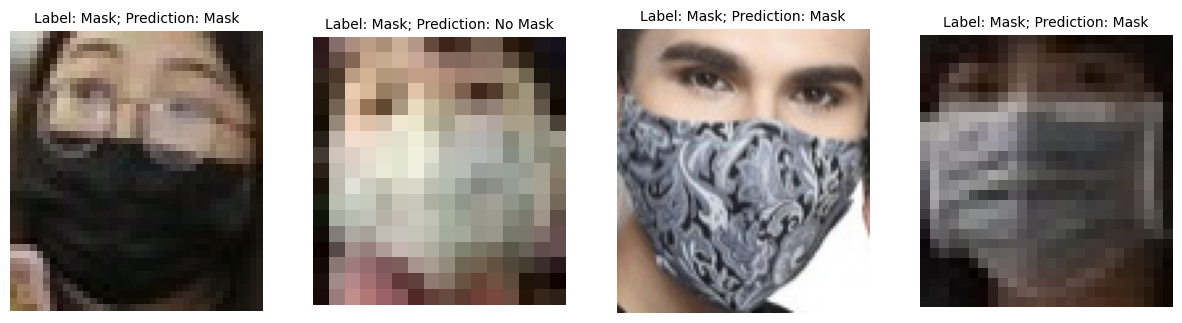

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_testimages, path_to_testlabels, model)
#
# path_to_testimages is the path to the test images
#
# path_to_testlabels is the path to the test labels
#
# model can be one of
#   - resnet50
#   - mobilenet
#   - custom_cnn
#   - svm_hog
#   - svm_sift

path_to_testimages = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test/images')
path_to_testlabels = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/test/labels')

MaskDetection(path_to_testimages, path_to_testlabels, resnet50)

# Test MaskDetectionVideo

This section should allow a quick test of the `MaskDetectionVideo` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetectionVideo` work.

In [ ]:
# this function processes the video and makes predictions using the resnet50 model
# this function saves the processed video with face detection and predicted labels
# to save_path as a XVID encoded video (saving as libx264 did not work),
# then it converts the video to a libx264 encoded
# video and saves it to display_path. later display_path is used to display
# the embed video player
#
# parameters -
# video_path: path were the raw video to be processed is
# save_path: path were the processed video (XVID) is saved
# display_path: path where the converted libx264 video will be saved and later used to display
def MaskDetectionVideo(video_path, save_path, display_path):
    print("Starting video processing...")

    # initialize MTCNN for face detection
    detector = MTCNN(keep_all=True)

    # create videocapture object to read frames in the video
    cap = cv2.VideoCapture(video_path)
    #if not cap.isOpened():
    #    print("Error: Unable to open video file.")
    #    return

    # get frame width
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    # get frame height
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # create variabes to store the bounding box and label
    prev_box = None
    prev_label = None

    # create list for the video frames
    video_frames = []

    downsample_factor = 3  # set the downsample factor for faster processing time

    # compress video with four character code as XVID
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    # create videowriter to save the video to the save_path
    out = cv2.VideoWriter(save_path, fourcc, 20.0, (frame_width // downsample_factor, frame_height // downsample_factor))

    # keep track of the frame count
    frame_count = 0

    # loop until the end of the video
    while True:
        ret, frame = cap.read() # read frame from video
        if not ret: # if frame is not succesfully read (end of vid), break loop
            break

        # resize frame for faster processing
        frame_resized = cv2.resize(frame, (frame_width // downsample_factor, frame_height // downsample_factor))

        # convert to RGB
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)

        # process every 10th frame with MTCNN and resnet50
        if frame_count % 10 == 0:
            boxes, _ = detector.detect(frame_rgb) # detect face in the frame
            if boxes is not None and len(boxes) > 0: # if no faces are found
                bbox = boxes[0]
                x1, y1, x2, y2 = map(int, bbox)
                roi = cv2.resize(frame_resized[y1:y2, x1:x2], (224, 224)) # extract bounding box region to be used for classification

                # define the transforms for roi
                transform = transforms.Compose([
                    transforms.ToPILImage(), # convert to PIL
                    transforms.Resize((224, 224)), # resize roi
                    transforms.ToTensor(), # conver to tensor
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize with ImageNet stats
                ])
                roi = transform(roi) # apply the transforms

                # make predictions on roi
                with torch.no_grad():
                    output = resnet50(roi.unsqueeze(0))
                    _, predicted = torch.max(output, 1)
                    label = predicted.item()
                    # map label prediction to text string to display
                    if label == 0:
                        label_text = "no mask"
                    elif label == 1:
                        label_text = "mask"
                    elif label == 2:
                        label_text = "mask improper"
                    else:
                        label_text = "unknown"

                prev_box = bbox # store current bounding box as prev_box
                prev_label = label_text # store current label as prev_label

        if prev_box is not None:
            x1, y1, x2, y2 = map(int, prev_box) # get coordinates of box
            cv2.rectangle(frame_resized, (x1, y1), (x2, y2), (0, 255, 0), 2) # draw green box on frame
            # draw label text string on frame
            cv2.putText(frame_resized, f'Label: {prev_label}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # write the processed frame to the output
        out.write(frame_resized)
        video_frames.append(frame_resized)
        frame_count += 1 # move to next frame

    cap.release() #release video capture
    out.release() # release video writer
    cv2.destroyAllWindows()

    print("Converting video to compatible format to display in Colab...")

    # load processed video
    video_clip = VideoFileClip(save_path)

    # write the video clip to a MP4 file
    video_clip.write_videofile(display_path, codec='libx264')

    # close the video clip
    video_clip.close()

    print("Processing and converting video done!")


Then, make a call to the `MaskDetectionVideo` function to see what results it produces.

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetectionVideo(video_path, save_path, display_path)
#
# video_path is the path to the raw video
#
# save_path is the path where the video will be saved after processing with MTCNN and the face mask detection model
#
# display_path is where the video will be saved after the processed video is converted to libx264 to be compatible to
# display in colab
#
# NOTE: when testing in a different google account, there were some issues with permissions to write the libx264 video to
# drive and displaying. i believe i fixed it after more testing, but this note is here
# just in case there are issues with the permissions on your account.
# (it should say "Processing and converting video done!" right before displaying the video)
# if permission issues persist, see next cell below where i have displayed the video that i processed from
# my original (owner/editor) google account, and you can also find it in the Video folder drive called libx264_output.mp4
#
# EDIT 2: to fix the issue, i had to give editor permission to the video folder, see note at the top of this
# notebook. the time stamp of the video i generated with the predictions is on the video libx264_output.mp4 in the
# video folder. the original unprocessed video is called mask_video.mp4 which should not be effected.
# but running this code will generate and display new processed videos with the predictions
# if you want to keep the timestamp of the videos i generated, change the save_path and display_path to something
# new to have the newly generated videos and the keep old videos that i generated

# path to raw video to be processed
# do not change, this is the name/path of my video "in the wild"
video_path = os.path.join(GOOGLE_DRIVE_PATH, 'Video/mask_video.mp4')

# path that saves the processed video as xvid
save_path = os.path.join(GOOGLE_DRIVE_PATH, 'Video/xvid_output.mp4')

# path that saves the converted (from xvid to libx264) video to display
display_path = os.path.join(GOOGLE_DRIVE_PATH, 'Video/test_output.mp4')

# call function
MaskDetectionVideo(video_path, save_path, display_path)

# display video
Video(display_path, embed=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# display video in case permission is not allowed above
video_output_path = os.path.join(GOOGLE_DRIVE_PATH, 'Video/libx264_output.mp4')
Video(display_path, embed=True)